In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), os.path.pardir))
import numpy as np
import torch
from utils.data_loader import JSONFileDataLoader
from utils.token_embedders.glove_json_embedder import GloveJsonEmbedder
from utils.token_embedders.glove_embedder import GloveEmbedder
from utils.token_embedders.elmo_embedder import ElmoEmbedder
from utils.token_embedders.fasttext_embedder import FasttextEmbedder
from framework import FewShotREFramework
from models.sentence_encoders.cnn.sentence_encoder import CNNSentenceEncoder
from models.sentence_encoders.inception_cnn.sentence_encoder import InceptionCNNSentenceEncoder
from models.sentence_encoders.entity_aware_attention_rnn.sentence_encoder import EntityAwareAttentionRnn
from models.fewshot.proto import Proto

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
cuda = True

model_name = 'proto'
N = 5
K = 5
# if len(sys.argv) > 1:
#     model_name = sys.argv[1]
# if len(sys.argv) > 2:
#     N = int(sys.argv[2])
# if len(sys.argv) > 3:
#     K = int(sys.argv[3])

print("{}-way-{}-shot Few-Shot Relation Classification".format(N, K))
print("Model: {}".format(model_name))

max_length = 40
data_path = os.path.join(os.path.abspath(''), os.path.pardir, 'data')
train_data_loader = JSONFileDataLoader(os.path.join(data_path, 'train.json'), max_length=max_length, cuda=cuda)
val_data_loader = JSONFileDataLoader(os.path.join(data_path, 'val.json'), max_length=max_length, cuda=cuda)
test_data_loader = JSONFileDataLoader(os.path.join(data_path, 'test.json'), max_length=max_length, cuda=cuda)

# word_embedder = GloveJsonEmbedder(word_vec_file_name='./data/glove/glove.6B.50d.json')
# word_embedder = ElmoEmbedder(cuda=True, cuda_out=cuda)
# word_embedder = FasttextEmbedder(cuda=cuda)
word_vec_dim = 100
word_embedder = GloveEmbedder(vec_dim=word_vec_dim, cuda=cuda, 
                              vectors_path=os.path.join(data_path, 'glove/glove.6B.{}d.txt').format(word_vec_dim))

framework = FewShotREFramework(train_data_loader, val_data_loader, test_data_loader)
# sentence_encoder = CNNSentenceEncoder(word_embedder, max_length, hidden_size=230)
# sentence_encoder = InceptionCNNSentenceEncoder(word_embedder, max_length, pos_embedding_dim=3, sizes=[{3: 230}])
# sentence_encoder = InceptionCNNSentenceEncoder(word_embedder, max_length, sizes=[{3: 200, 5:200, 7:200}, {3: 300, 5:300, 7:300}])


5-way-5-shot Few-Shot Relation Classification
Model: proto
Loading data file...
Finish loading
Eliminating case sensitive problem...
Finish eliminating
Pre-processing data...
Finish pre-processing
Storing processed files...
Finish storing
Loading data file...
Finish loading
Eliminating case sensitive problem...
Finish eliminating
Pre-processing data...
Finish pre-processing
Storing processed files...
Finish storing
Loading data file...
Finish loading
Eliminating case sensitive problem...
Finish eliminating
Pre-processing data...
Finish pre-processing
Storing processed files...
Finish storing
Init GloVe embedder
400000 vectors with dim 100


In [3]:
def hyperopt_single_param(encoder_model_class:type, fewshot_model_class:type, framework:FewShotREFramework,
                          param_name:str, param_values:list, other_params:dict, N=5, K=5):
    print('Optimizing {} with possible values: {}'.format(param_name, param_values))
    scores = []
    for i, v in enumerate(param_values):
        print('Iteration {}: {} = {}'.format(i+1, param_name, v))
        sentence_encoder = encoder_model_class(**{param_name:v}, **other_params)
        model = fewshot_model_class(sentence_encoder, hidden_size=sentence_encoder.hidden_size)
        score = framework.train(model, 'tmp', 4, 20, N, K, 5, cuda=cuda, learning_rate=1, train_iter=2000)
        scores.append(score)
        print('Score: {:.4f}'.format(score))
        print('-'*20)
    best_val = param_values[np.argmax(scores)]
    return scores, best_val

In [4]:
params = {
    'word_embedder': word_embedder, 
    'max_length': max_length, 
    'hidden_size': 100, 
    'pos_embedding_dim': 50, 
    'n_heads': 4,
    'attention_dim': 50,
    'num_latent_types': 3,
    'cuda': cuda,
    'dropout_we': 0, 
    'dropout_rnn': 0, 
    'dropout_eaa': 0
}

In [5]:
optimized_param = 'num_latent_types'
del params[optimized_param]
# values = [1, 3, 5, 7, 10, 15, 20, 30, 40, 50]
values = [1, 3, 5, 10, 20, 30]

In [6]:
params

{'word_embedder': GloveEmbedder(),
 'max_length': 40,
 'hidden_size': 100,
 'pos_embedding_dim': 50,
 'n_heads': 4,
 'attention_dim': 50,
 'cuda': True,
 'dropout_we': 0,
 'dropout_rnn': 0,
 'dropout_eaa': 0}

### Select number of entity latent types

In [7]:
print('Parameter {} optimization'.format(optimized_param))
scores, best_val = hyperopt_single_param(encoder_model_class=EntityAwareAttentionRnn, 
                          fewshot_model_class=Proto,
                          framework=framework,
                          param_name=optimized_param,
                          param_values=values,
                          other_params=params,
                          N=5, K=5)
print('Optimal value {} with score {}'.format(best_val, np.max(scores)))

Parameter num_latent_types optimization
Optimizing num_latent_types with possible values: [1, 3, 5, 10, 20, 30]
Iteration 1: num_latent_types = 1
Start training...


/home/clement/Courses/Other/Deep_NLP/spring-2019/work/project/code/fewrel-project-ipavlov/env/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


step: 2000 | loss: 0.778004, accuracy: 74.79%
[EVAL] step: 1000 | accuracy: 85.05%
Best checkpoint

####################

Finish training tmp

Successfully loaded checkpoint './checkpoint/tmp.pth.tar'
[EVAL] step: 3000 | accuracy: 84.88%
Test accuracy: 0.8488033129970233
Score: 0.8488
--------------------
Iteration 2: num_latent_types = 3
Start training...
step: 2000 | loss: 0.785432, accuracy: 74.58%
[EVAL] step: 1000 | accuracy: 85.28%
Best checkpoint

####################

Finish training tmp

Successfully loaded checkpoint './checkpoint/tmp.pth.tar'
[EVAL] step: 3000 | accuracy: 85.12%
Test accuracy: 0.8511833134293556
Score: 0.8512
--------------------
Iteration 3: num_latent_types = 5
Start training...
step: 2000 | loss: 0.785122, accuracy: 74.57%
[EVAL] step: 1000 | accuracy: 85.60%
Best checkpoint

####################

Finish training tmp

Successfully loaded checkpoint './checkpoint/tmp.pth.tar'
[EVAL] step: 3000 | accuracy: 85.31%
Test accuracy: 0.8530866470734279
Score: 0.8

Text(0.5, 1.0, 'Parameter "num_latent_types" optimization')

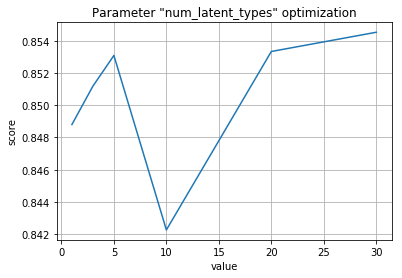

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(values, scores)
plt.xlabel('value')
plt.ylabel('score')
plt.grid()
plt.title('Parameter "{}" optimization'.format(optimized_param))